In [1]:
# Core Libraries
import pandas as pd
import numpy as np

# Visualization Libraries
import seaborn as sns
import matplotlib.pyplot as plt

# Preprocessing & Modeling
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree

# Evaluation Metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve

# Warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load the training data
df = pd.read_csv("D:/Machine Learning Projects/Loan Approval Predictor/train.csv")

# Quick view
print("Shape of dataset:", df.shape)
df.head()

Shape of dataset: (614, 13)


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [3]:
print("Column names in the dataset:")
print(df.columns.tolist())

Column names in the dataset:
['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status']


In [4]:
# Check for missing values
print("Missing values per column:\n", df.isnull().sum())

# Fill missing categorical values with mode
for col in ['Gender', 'Married', 'Dependents', 'Self_Employed', 'Credit_History', 'Loan_Amount_Term']:
    df[col].fillna(df[col].mode()[0], inplace=True)

# Fill missing numeric values with median
df['LoanAmount'].fillna(df['LoanAmount'].median(), inplace=True)

# Confirm missing values handled
print("\nRemaining missing values:\n", df.isnull().sum())

Missing values per column:
 Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

Remaining missing values:
 Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64


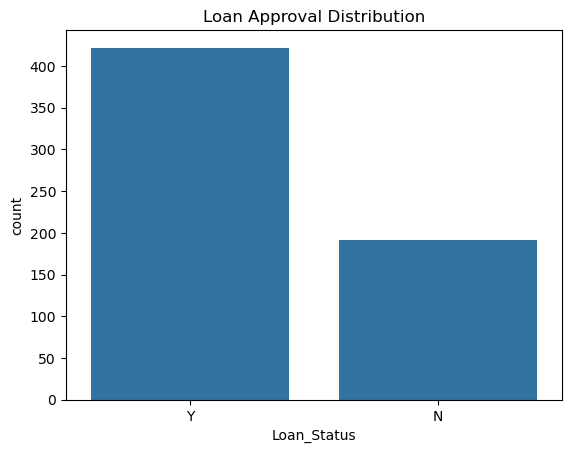

In [5]:
# 1. Loan Status Distribution
sns.countplot(data=df, x='Loan_Status')
plt.title("Loan Approval Distribution")
plt.show()

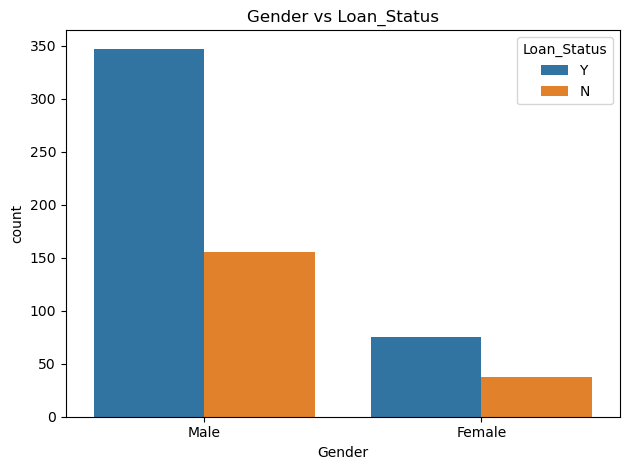

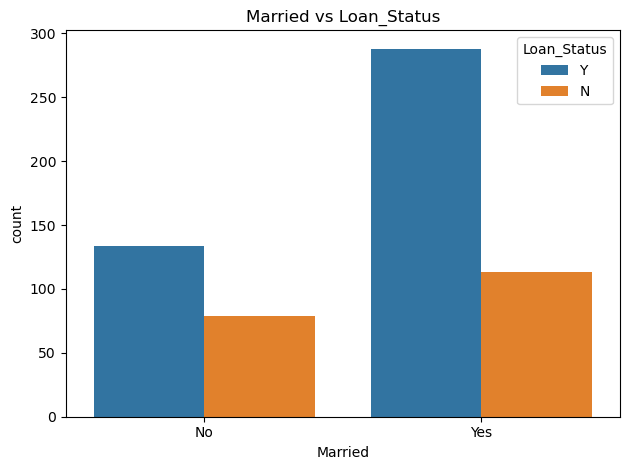

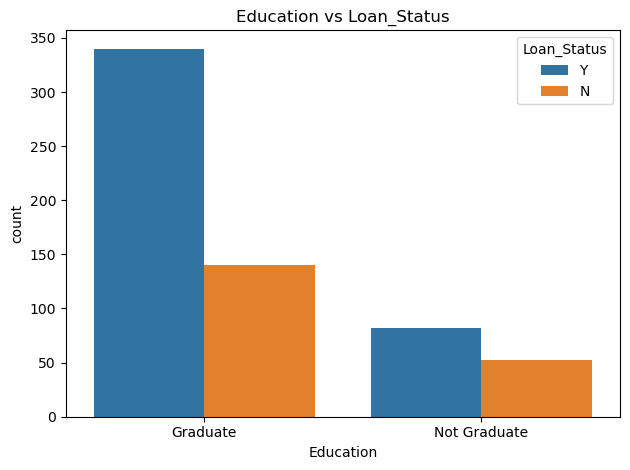

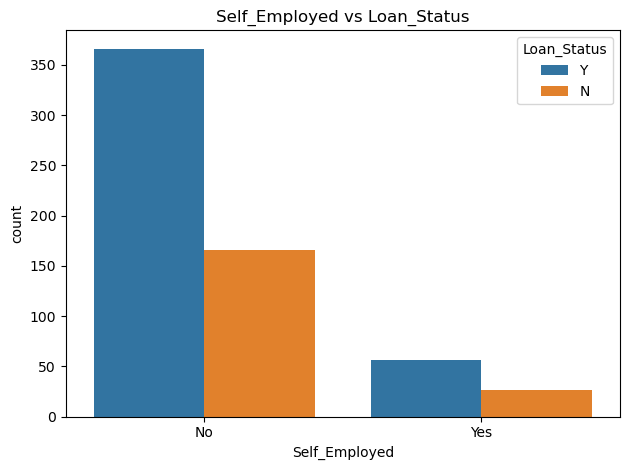

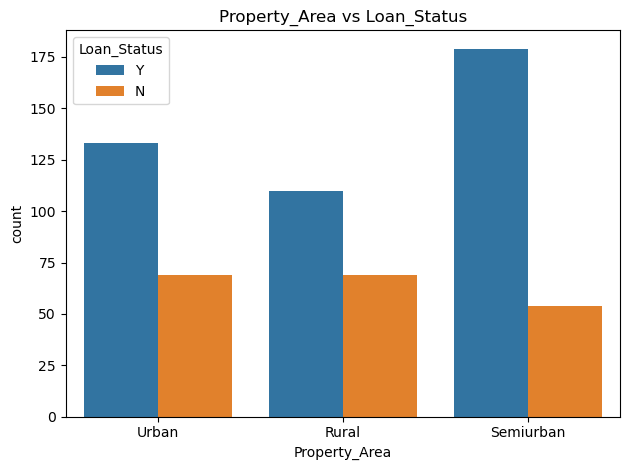

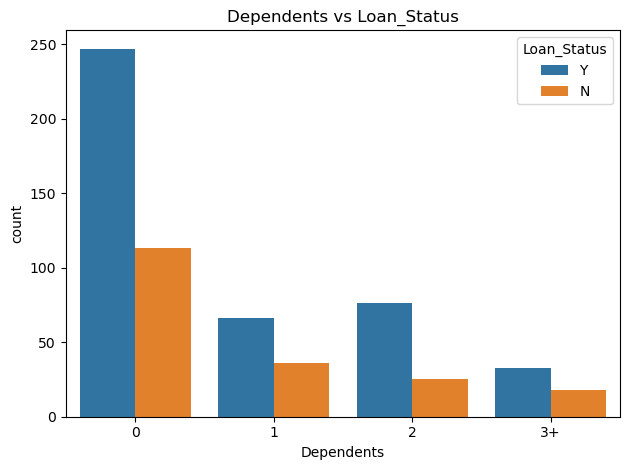

In [6]:
# 2. Countplots for categorical variables
cat_cols = ['Gender', 'Married', 'Education', 'Self_Employed', 'Property_Area', 'Dependents']
for col in cat_cols:
    sns.countplot(data=df, x=col, hue='Loan_Status')
    plt.title(f"{col} vs Loan_Status")
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

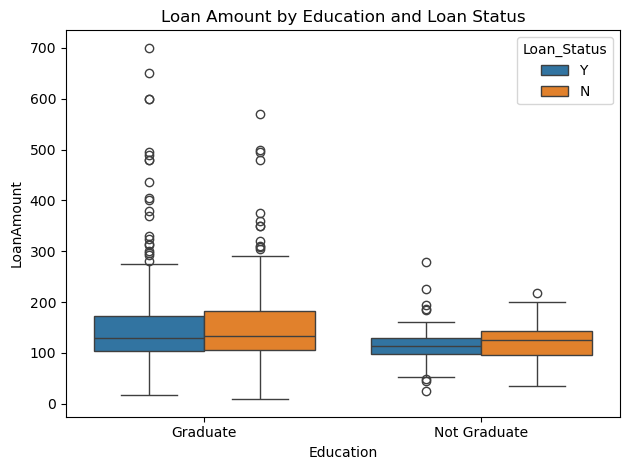

In [7]:
# 3. Boxplot: LoanAmount vs Education
sns.boxplot(data=df, x='Education', y='LoanAmount', hue='Loan_Status')
plt.title("Loan Amount by Education and Loan Status")
plt.tight_layout()
plt.show()

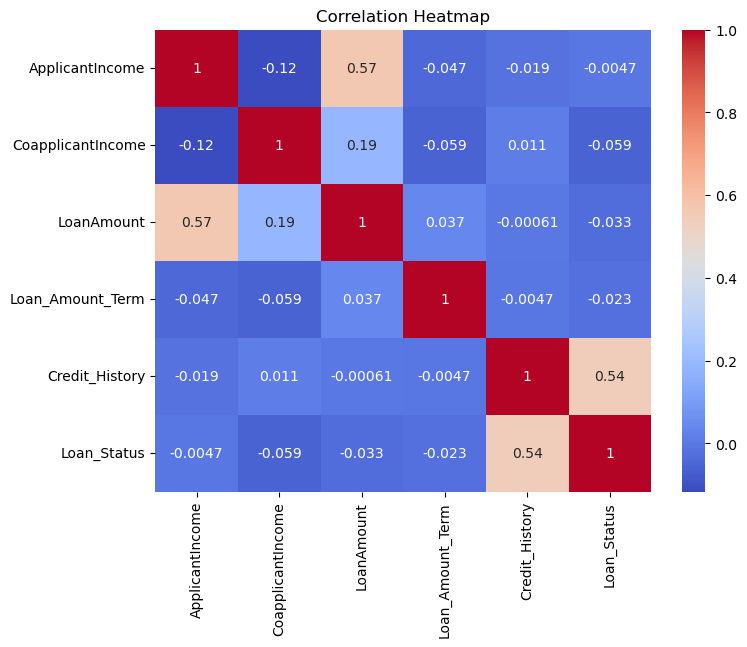

In [8]:
# 4. Correlation Heatmap (with numeric conversion of target)
df_corr = df.copy()
df_corr['Loan_Status'] = df_corr['Loan_Status'].map({'Y': 1, 'N': 0})
plt.figure(figsize=(8, 6))
sns.heatmap(df_corr.select_dtypes(include=np.number).corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

In [9]:
# Drop Loan_ID as it's not useful for prediction
df.drop('Loan_ID', axis=1, inplace=True)

# Convert target variable to numeric
df['Loan_Status'] = df['Loan_Status'].map({'Y': 1, 'N': 0})

# Replace '3+' with 3 and convert to int
df['Dependents'] = df['Dependents'].replace('3+', 3).astype(int)

# Label encode binary categorical columns
binary_cols = ['Gender', 'Married', 'Education', 'Self_Employed']
le = LabelEncoder()
for col in binary_cols:
    df[col] = le.fit_transform(df[col])

# One-hot encode Property_Area
df = pd.get_dummies(df, columns=['Property_Area'], drop_first=True)

# Final columns
print("Final columns:", df.columns.tolist())

Final columns: ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History', 'Loan_Status', 'Property_Area_Semiurban', 'Property_Area_Urban']


In [10]:
# Separate features and target variable
X = df.drop('Loan_Status', axis=1)
y = df['Loan_Status']

# Split into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Confirm the shapes
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train distribution:\n", y_train.value_counts(normalize=True))
print("y_test distribution:\n", y_test.value_counts(normalize=True))

X_train shape: (491, 12)
X_test shape: (123, 12)
y_train distribution:
 Loan_Status
1    0.686354
0    0.313646
Name: proportion, dtype: float64
y_test distribution:
 Loan_Status
1    0.691057
0    0.308943
Name: proportion, dtype: float64


In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize the model
logreg = LogisticRegression(max_iter=1000, random_state=42)

# Train on training data
logreg.fit(X_train, y_train)

# Predict on test set
y_pred_logreg = logreg.predict(X_test)
y_prob_logreg = logreg.predict_proba(X_test)[:, 1]  # Probabilities for ROC curve
log_reg_accuracy = accuracy_score(y_test, y_pred_logreg)

In [12]:
accuracy = accuracy_score(y_test, y_pred_logreg)
print("Accuracy of Logistic Regression:", round(accuracy * 100, 2), "%")

Accuracy of Logistic Regression: 86.18 %


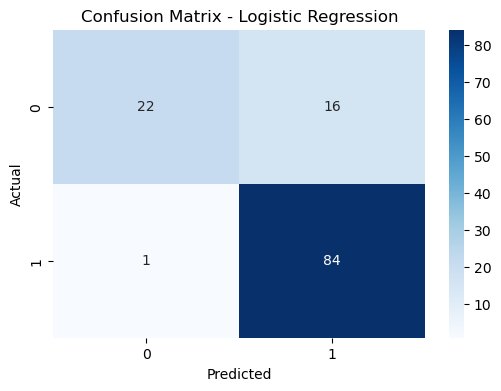

In [13]:
cm = confusion_matrix(y_test, y_pred_logreg)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [14]:
print("Classification Report:\n")
print(classification_report(y_test, y_pred_logreg))

Classification Report:

              precision    recall  f1-score   support

           0       0.96      0.58      0.72        38
           1       0.84      0.99      0.91        85

    accuracy                           0.86       123
   macro avg       0.90      0.78      0.81       123
weighted avg       0.88      0.86      0.85       123



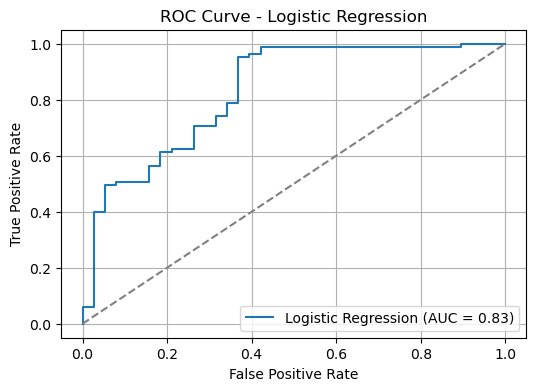

ROC-AUC Score: 0.83


In [15]:
roc_auc = roc_auc_score(y_test, y_prob_logreg)
fpr, tpr, thresholds = roc_curve(y_test, y_prob_logreg)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label='Logistic Regression (AUC = %0.2f)' % roc_auc)
plt.plot([0,1], [0,1], linestyle='--', color='gray')
plt.title("ROC Curve - Logistic Regression")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
plt.show()

print("ROC-AUC Score:", round(roc_auc, 4))

In [16]:
cv_scores = cross_val_score(logreg, X, y, cv=5, scoring='accuracy')
print("Cross-Validation Accuracy Scores:", cv_scores)
print("Mean CV Accuracy:", round(cv_scores.mean() * 100, 2), "%")

Cross-Validation Accuracy Scores: [0.81300813 0.77235772 0.7804878  0.85365854 0.81147541]
Mean CV Accuracy: 80.62 %


In [17]:
# We assume 'df' is the final cleaned dataframe used earlier
# and it does NOT contain 'Loan_ID'

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# If 'Loan_ID' has already been dropped, don't include it here
X = df.drop(columns=['Loan_Status'])  # Only drop the target column
y = df['Loan_Status']

# Split data into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Shapes - Train:", X_train.shape, "| Test:", X_test.shape)


Shapes - Train: (491, 12) | Test: (123, 12)


In [18]:
# Initialize the Decision Tree model
dt_model = DecisionTreeClassifier(random_state=42)

# Fit the model to the training data
dt_model.fit(X_train, y_train)


DecisionTreeClassifier(random_state=42)

In [19]:
# Predict on test set
y_pred_dt = dt_model.predict(X_test)

# Evaluate
print("Accuracy Score:", accuracy_score(y_test, y_pred_dt))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_dt))
print("\nClassification Report:\n", classification_report(y_test, y_pred_dt))

Accuracy Score: 0.7317073170731707

Confusion Matrix:
 [[23 15]
 [18 67]]

Classification Report:
               precision    recall  f1-score   support

           0       0.56      0.61      0.58        38
           1       0.82      0.79      0.80        85

    accuracy                           0.73       123
   macro avg       0.69      0.70      0.69       123
weighted avg       0.74      0.73      0.73       123



In [20]:
# Re-train with better parameters
dt_model_tuned = DecisionTreeClassifier(
    max_depth=4,                # limit depth
    min_samples_split=10,       # require more samples to split
    min_samples_leaf=4,         # require more samples in leaf
    class_weight='balanced',    # balance classes
    random_state=42
)

dt_model_tuned.fit(X_train, y_train)

# Predictions
y_pred_tuned = dt_model_tuned.predict(X_test)

# Evaluation
print("Tuned Accuracy Score:", accuracy_score(y_test, y_pred_tuned))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_tuned))
print("\nClassification Report:\n", classification_report(y_test, y_pred_tuned))

Tuned Accuracy Score: 0.8130081300813008

Confusion Matrix:
 [[23 15]
 [ 8 77]]

Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.61      0.67        38
           1       0.84      0.91      0.87        85

    accuracy                           0.81       123
   macro avg       0.79      0.76      0.77       123
weighted avg       0.81      0.81      0.81       123



In [21]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    'max_depth': [3, 4, 5, 6],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': [None, 'balanced']
}

# Initialize model
dt = DecisionTreeClassifier(random_state=42)

# Grid Search with 5-fold cross-validation
grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, 
                           cv=5, n_jobs=-1, scoring='accuracy')

grid_search.fit(X_train, y_train)

# Best model
best_dt_model = grid_search.best_estimator_

# Predict with best model
y_pred_best = best_dt_model.predict(X_test)

# Evaluate
print("Best Accuracy:", accuracy_score(y_test, y_pred_best))
print("\nBest Params:", grid_search.best_params_)
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_best))
print("\nClassification Report:\n", classification_report(y_test, y_pred_best))

Best Accuracy: 0.8455284552845529

Best Params: {'class_weight': None, 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}

Confusion Matrix:
 [[20 18]
 [ 1 84]]

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.53      0.68        38
           1       0.82      0.99      0.90        85

    accuracy                           0.85       123
   macro avg       0.89      0.76      0.79       123
weighted avg       0.86      0.85      0.83       123



In [22]:
print("Logistic Regression Accuracy: {:.2f}%".format(log_reg_accuracy * 100))
print("Decision Tree Accuracy (Tuned): {:.2f}%".format(accuracy_score(y_test, y_pred_best) * 100))

Logistic Regression Accuracy: 86.18%
Decision Tree Accuracy (Tuned): 84.55%


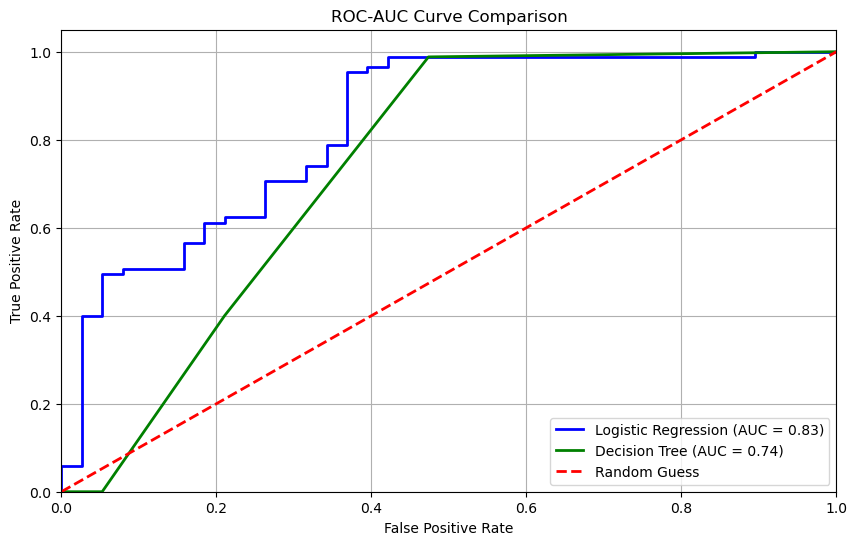

In [23]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Predict probabilities
log_probs = logreg.predict_proba(X_test)[:, 1]
tree_probs = best_dt_model.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC for Logistic Regression
fpr_log, tpr_log, _ = roc_curve(y_test, log_probs)
roc_auc_log = auc(fpr_log, tpr_log)

# Compute ROC curve and AUC for Decision Tree
fpr_tree, tpr_tree, _ = roc_curve(y_test, tree_probs)
roc_auc_tree = auc(fpr_tree, tpr_tree)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(fpr_log, tpr_log, color='blue', lw=2, label='Logistic Regression (AUC = {:.2f})'.format(roc_auc_log))
plt.plot(fpr_tree, tpr_tree, color='green', lw=2, label='Decision Tree (AUC = {:.2f})'.format(roc_auc_tree))
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC Curve Comparison')
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [24]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Recalculate and show metrics
y_pred_logreg = logreg.predict(X_test)
y_pred_dt = best_dt_model.predict(X_test)

print("Logistic Regression Results:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_logreg) * 100:.2f}%")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_logreg))
print("Classification Report:")
print(classification_report(y_test, y_pred_logreg))

print("\nDecision Tree (Tuned) Results:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_dt) * 100:.2f}%")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_dt))
print("Classification Report:")
print(classification_report(y_test, y_pred_dt))

Logistic Regression Results:
Accuracy: 86.18%
Confusion Matrix:
[[22 16]
 [ 1 84]]
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.58      0.72        38
           1       0.84      0.99      0.91        85

    accuracy                           0.86       123
   macro avg       0.90      0.78      0.81       123
weighted avg       0.88      0.86      0.85       123


Decision Tree (Tuned) Results:
Accuracy: 84.55%
Confusion Matrix:
[[20 18]
 [ 1 84]]
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.53      0.68        38
           1       0.82      0.99      0.90        85

    accuracy                           0.85       123
   macro avg       0.89      0.76      0.79       123
weighted avg       0.86      0.85      0.83       123



In [25]:
# Load the test data
test_df = pd.read_csv('D:/Machine Learning Projects/Loan Approval Predictor/test.csv')

# Save Loan_ID for submission or display
loan_ids = test_df['Loan_ID']

# Drop Loan_ID for preprocessing
test_df = test_df.drop('Loan_ID', axis=1)

# Fill missing values — use the same strategy as training set
for col in test_df.columns:
    if test_df[col].dtype == 'object':
        test_df[col] = test_df[col].fillna(test_df[col].mode()[0])
    else:
        test_df[col] = test_df[col].fillna(test_df[col].median())

# Encode categorical variables — must use same encoding as training
test_df = pd.get_dummies(test_df)

# Match columns with training data
missing_cols = set(X.columns) - set(test_df.columns)
for col in missing_cols:
    test_df[col] = 0
test_df = test_df[X.columns]  # Ensure same order

In [26]:
# Predict on the test set using the tuned Decision Tree
test_predictions = best_dt_model.predict(test_df)

# Create a submission-ready DataFrame
submission_df = pd.DataFrame({
    'Loan_ID': loan_ids,
    'Loan_Status': ['Y' if pred == 1 else 'N' for pred in test_predictions]
})

# Display first few predictions
submission_df.head()

,Loan_ID,Loan_Status
0,LP001015,Y
1,LP001022,Y
2,LP001031,Y
3,LP001035,Y
4,LP001051,Y


In [27]:
def predict_from_user_input():
    print("Enter the following details:")

    user_input = {
        'Gender': input("Gender (Male/Female): "),
        'Married': input("Married (Yes/No): "),
        'Dependents': input("Dependents (0/1/2/3+): "),
        'Education': input("Education (Graduate/Not Graduate): "),
        'Self_Employed': input("Self_Employed (Yes/No): "),
        'ApplicantIncome': float(input("ApplicantIncome: ")),
        'CoapplicantIncome': float(input("CoapplicantIncome: ")),
        'LoanAmount': float(input("LoanAmount (in thousands): ")),
        'Loan_Amount_Term': float(input("Loan_Amount_Term: ")),
        'Credit_History': float(input("Credit_History (1.0/0.0): ")),
        'Property_Area': input("Property_Area (Urban/Rural/Semiurban): ")
    }

    # Convert to DataFrame
    user_df = pd.DataFrame([user_input])

    # Preprocessing
    for col in user_df.columns:
        if user_df[col].dtype == 'object':
            user_df[col] = user_df[col].fillna(user_df[col].mode()[0])
        else:
            user_df[col] = user_df[col].fillna(user_df[col].median())

    user_df = pd.get_dummies(user_df)

    # Add missing columns from training
    for col in X.columns:
        if col not in user_df.columns:
            user_df[col] = 0

    user_df = user_df[X.columns]

    # Prediction
    prediction = best_dt_model.predict(user_df)[0]
    print("\nLoan Approved, Congratulations!" if prediction == 1 else "\nSorry, your loan has been rejected")

In [ ]:
predict_from_user_input()

Enter the following details:
